# [WIP]Bayesian Neural Networks in PyMC

以下に沿って実施.

[まだ写経しただけで内容はよくわかってない]

http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/

とりあえず
* PyMC3を用いて事前分布等を設定
* NN部分はTheanoでの実装

をやっているようだ。

最終的な各パラメータの信頼区間のようなものが見れるため、
どの程度信頼できそうか、が見ることができるのかなぁ、という印象

## Generating data
とりあえず簡単なトイデータで実施

In [1]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

In [2]:
# moonデータ
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

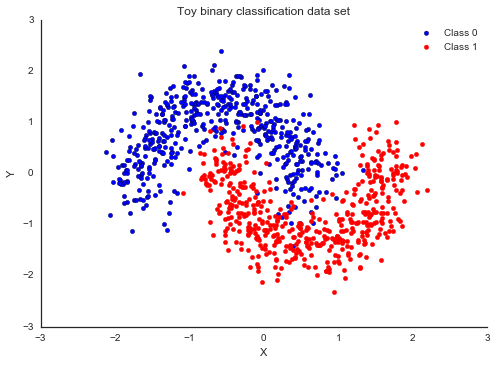

In [5]:
# プロット
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [6]:
# Trick: Turn inputs and outputs into shared variables. 
# It's still the same thing, but we can later change the values of the shared variable 
# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 5

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)

In [7]:
with pm.Model() as neural_network:
    # Weights from input to hidden layer
    # input->1層目のウェイト：正規分布
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(X.shape[1], n_hidden), 
                             testval=init_1)
    
    # Weights from 1st to 2nd layer
    # 1->2層目のウェイト：正規分布
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)
    
    # Weights from hidden layer to output
    # 2->output層目のウェイト：正規分布
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(n_hidden,), 
                              testval=init_out)
    
    # Build neural-network using tanh activation function
    # 活性化関数にはtanhとシグモイド関数を使用
    act_1 = T.tanh(T.dot(ann_input, 
                         weights_in_1))
    act_2 = T.tanh(T.dot(act_1, 
                         weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, 
                                   weights_2_out))
    
    # Binary classification -> Bernoulli likelihood
    # 2値分類のためベルヌーイに
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=ann_output)

In [9]:
%%time

with neural_network:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = pm.variational.advi(n=50000)

Iteration 0 [0%]: ELBO = -285.65
Iteration 5000 [10%]: Average ELBO = -399.39
Iteration 10000 [20%]: Average ELBO = -259.41
Iteration 15000 [30%]: Average ELBO = -224.78
Iteration 20000 [40%]: Average ELBO = -209.95
Iteration 25000 [50%]: Average ELBO = -197.13
Iteration 30000 [60%]: Average ELBO = -174.7
Iteration 35000 [70%]: Average ELBO = -151.95
Iteration 40000 [80%]: Average ELBO = -138.58
Iteration 45000 [90%]: Average ELBO = -132.69
Finished [100%]: Average ELBO = -129.72
CPU times: user 15.4 s, sys: 1.4 s, total: 16.8 s
Wall time: 1min 25s


In [10]:
with neural_network:
    trace = pm.variational.sample_vp(v_params, draws=5000)

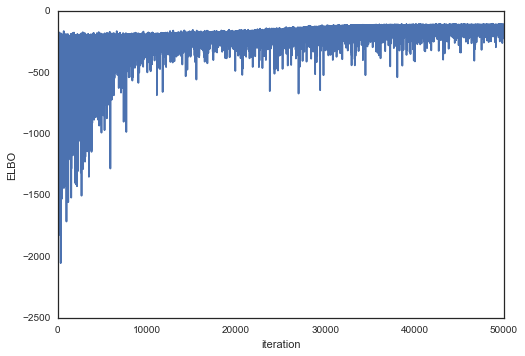

In [12]:
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration')

## train our model


In [13]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

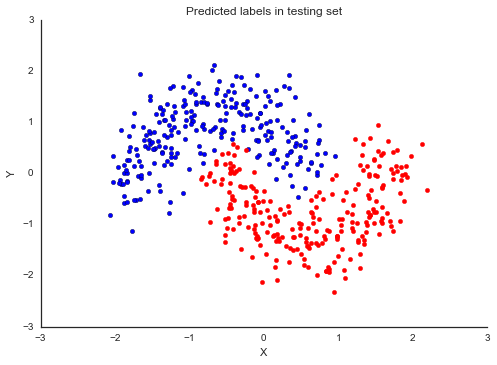

In [15]:
# テストデータだけの散布図
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [16]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 95.6%


## どのように学習されているかチェック


In [17]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [18]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

### 分類の確率で色づけされたものがこちら

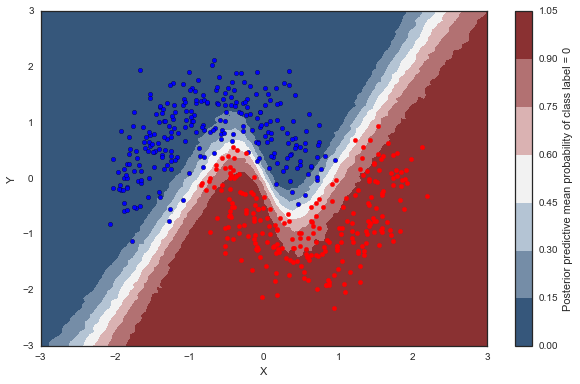

In [19]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

### 予測値の不確実度合いを可視化

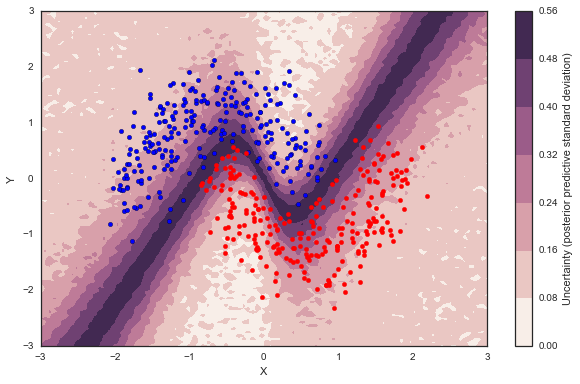

In [20]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

## Mini-batch ADVI

In [21]:
# Set back to original data to retrain
ann_input.set_value(X_train)
ann_output.set_value(Y_train)

# Tensors and RV that will be using mini-batches
minibatch_tensors = [ann_input, ann_output]
minibatch_RVs = [out]

# Generator that returns mini-batches in each iteration
def create_minibatch(data):
    rng = np.random.RandomState(0)
    
    while True:
        # Return random data samples of set size 100 each iteration
        ixs = rng.randint(len(data), size=50)
        yield data[ixs]

minibatches = zip(
    create_minibatch(X_train), 
    create_minibatch(Y_train),
)

total_size = len(Y_train)

In [22]:
%%time

with neural_network:
    # Run advi_minibatch
    v_params = pm.variational.advi_minibatch(
        n=50000, minibatch_tensors=minibatch_tensors, 
        minibatch_RVs=minibatch_RVs, minibatches=minibatches, 
        total_size=total_size, learning_rate=1e-2, epsilon=1.0
    )

Iteration 0 [0%]: ELBO = -221.33
Iteration 5000 [10%]: Average ELBO = -211.02
Iteration 10000 [20%]: Average ELBO = -124.47
Iteration 15000 [30%]: Average ELBO = -118.76
Iteration 20000 [40%]: Average ELBO = -119.61
Iteration 25000 [50%]: Average ELBO = -119.36
Iteration 30000 [60%]: Average ELBO = -119.89
Iteration 35000 [70%]: Average ELBO = -119.1
Iteration 40000 [80%]: Average ELBO = -119.35
Iteration 45000 [90%]: Average ELBO = -118.97
Finished [100%]: Average ELBO = -119.85
CPU times: user 8.98 s, sys: 218 ms, total: 9.2 s
Wall time: 12.3 s


In [23]:
with neural_network:    
    trace = pm.variational.sample_vp(v_params, draws=5000)

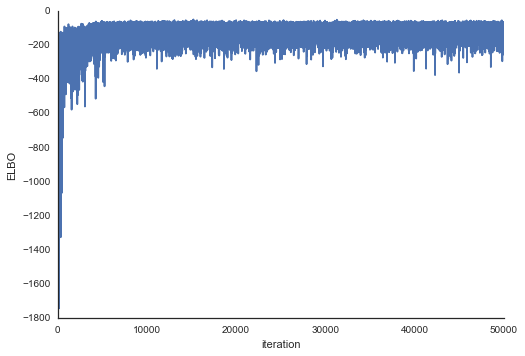

In [24]:
# プロット
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration')
sns.despine()

## ニューラルネットのウェイトの不確実性を確認

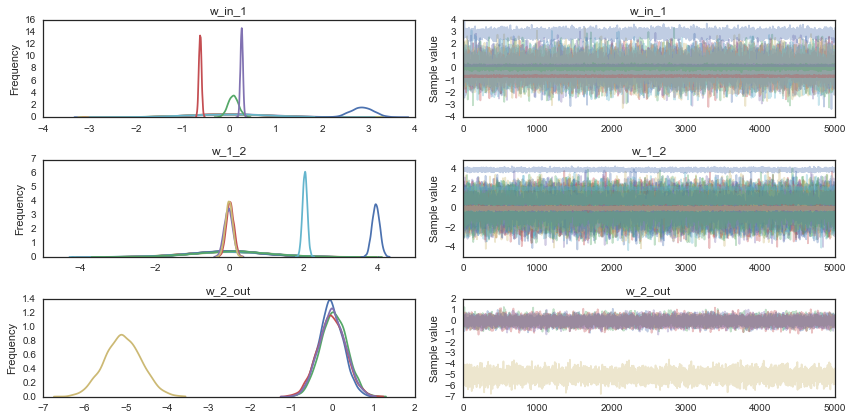

In [25]:
pm.traceplot(trace);